In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Load the dataset
data = pd.read_csv("wtbdata_245days.csv")
tlocdata = pd.read_csv("turbine_location.csv")

#Create a timestamp field
data['date'] = [t for t in zip(data['Day'].values, data['Tmstamp'].values)]

In [10]:
# For the given time t, due to the faulty performance of some thermometers we are assuming some error will happen
# while calculating External Temperatures and hence those values which fall outside the defined range will be 
# assigned a median value
f = 'Etmp'

# calulate the mean/std/median of the external temp for each date
tmp_data = data[['date','TurbID','Tmstamp','Day',f]]
mu = tmp_data.groupby('date')[f].mean().reset_index().rename({f:'mean'}, axis=1)
std = tmp_data.groupby('date')[f].std().reset_index().rename({f:'std'}, axis=1)
median = tmp_data.groupby('date')[f].median().reset_index().rename({f:'median'}, axis=1)

# Adding the mean,median and standard deviation for the external temperature of all the dates to the dataset
f_limit_df = pd.merge(mu, std, how='left', left_on='date', right_on='date')
f_limit_df = pd.merge(f_limit_df, median, how='left', left_on='date', right_on='date')

# calulate the range 
f_limit_df['bottom_limit'] = f_limit_df['mean'] - 3*f_limit_df['std']
f_limit_df['upper_limit'] = f_limit_df['mean'] + 3*f_limit_df['std']

# Add those within the range to the dataset
data = pd.merge(data, f_limit_df[['date','bottom_limit','upper_limit', 'median']], how='left', left_on='date', right_on='date')
data[f'abnormal_{f}'] = (data[f] < data['bottom_limit']) | (data[f] > data['upper_limit'])

# Delete the columns which were created to perform the above function after assigning median values to the 
# temperature values outside the range
data.loc[data[f'abnormal_{f}'], f] = 0
data[f] = data[f'abnormal_{f}']*data['median'] + data[f]
data = data.drop(['bottom_limit','upper_limit','median','date',f'abnormal_{f}'], axis=1)

In [11]:
# # We define the range for abnormal values of Nacelle Directions
# data['abnormal_Ndir'] = (data['Ndir'] < -720) | (data['Ndir'] > 720)
# interp_feat = 'Ndir'
# data.loc[data[f'abnormal_{interp_feat}'], interp_feat] = np.nan
# # Interpolate for each turbine
# ab_turbids = data[data[f'abnormal_{interp_feat}']]['TurbID'].unique()
# new_data = []
# for turbid, a_data in data.groupby('TurbID'):
#     if turbid not in ab_turbids:
#         new_data.append(a_data) 
#     else:
#         # Interpolate first, then  back/forward fill to handle with the missing value on the first or bottom row
#         a_data[interp_feat] = a_data[interp_feat].interpolate()
#         a_data[interp_feat] = a_data[interp_feat].fillna(method='bfill')   
#         a_data[interp_feat] = a_data[interp_feat].fillna(method='ffill') 
#         new_data.append(a_data)
# data = pd.concat(new_data, axis=0) 
# data = data.drop('abnormal_Ndir', axis=1)
# del new_data
# print(data.size)

In [12]:
nan_rows = data.isnull().any(axis=1)

# We first define the abnormal values by defining the abnormal conditions
invalid_cond = (data['Patv'] < 0) | \
                   ((data['Patv'] == 0) & (data['Wspd'] > 2.5)) | \
                   ((data['Pab1'] > 89) | (data['Pab2'] > 89) | (data['Pab3'] > 89)) | \
                   ((data['Wdir'] < -180) | (data['Wdir'] > 180) | (data['Ndir'] < -720) |\
                    (data['Ndir'] > 720))

# Except the turbid, day and tmstmp values of the invalid rows make everything else null
req_cols = set(data.columns) - {'TurbID', 'Day', 'Tmstamp'}
data.loc[invalid_cond, list(req_cols)] = np.nan

# Defining the abnormal values for power
data.loc[(data['Prtv'] < 0) & (data['Patv'] > 0), 'Prtv'] = np.nan
data.loc[(data['Prtv'] < 0) & (data['Patv'] <= 0), 'Prtv'] = 0
data.loc[data['Patv'] < 0, 'Patv'] = 0

# Using the max of the 3 pitch blade angles instead of the individual blades
data['Pab_max'] = data[['Pab1', 'Pab2', 'Pab3']].max(axis=1)
data = data.drop(columns=['Pab1', 'Pab2', 'Pab3'])

# Filling in the null values
data = data.groupby(data.TurbID.values).ffill().bfill()

# Convert datetime columns to numerical type
data['Tmstamp'] = pd.to_datetime(data['Tmstamp'])
data['Tmstamp'] = pd.to_numeric(data['Tmstamp'])

[09:48:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



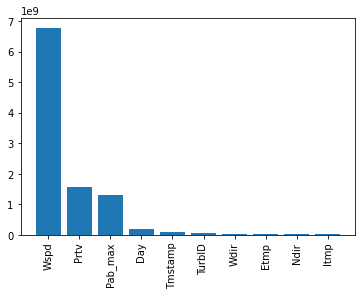

In [13]:
# Defining the XGBoost model parameters
params = {
    "objective": "reg:squarederror",
    "eval_metric": "auc",
    "max_depth": 4,
    "learning_rate": 0.1,
    "silent": 1
}

# Training the XGBoost model
dtrain = xgb.DMatrix(data.drop(["Patv"], axis=1), label=data["Patv"])
model = xgb.train(params, dtrain, num_boost_round=100)

# Calculate feature importance
importance = model.get_score(importance_type="gain")
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Plotting the graph to show the importance of the various features in the dataset
plt.bar(range(len(importance)), [val[1] for val in importance], align="center")
plt.xticks(range(len(importance)), [val[0] for val in importance])
plt.xticks(rotation=90)
plt.show()

In [14]:
# Normalizing hours and minutes of a time series dataset
temp = pd.to_datetime(data['Tmstamp'])
hours = temp.dt.hour
minutes = temp.dt.minute

normalized_hours = np.sin(2*np.pi*hours/24)
normalized_minutes = np.cos(2*np.pi*minutes/60)

# Adding the normalized values to the dataset
data['hour'] = normalized_hours
data['minute'] = normalized_minutes

print(data)

         TurbID  Day              Tmstamp  Wspd  Wdir   Etmp   Itmp    Ndir  \
0             1    1  1677456000000000000  6.17 -3.99  30.73  41.80   25.92   
1             1    1  1677456600000000000  6.17 -3.99  30.73  41.80   25.92   
2             1    1  1677457200000000000  6.27 -2.18  30.60  41.63   20.91   
3             1    1  1677457800000000000  6.42 -0.73  30.52  41.52   20.91   
4             1    1  1677458400000000000  6.25  0.89  30.49  41.38   20.91   
...         ...  ...                  ...   ...   ...    ...    ...     ...   
4727515     134  245  1677539400000000000  7.79  2.80  -0.07   3.95  216.51   
4727516     134  245  1677540000000000000  8.06  4.39   0.23   3.94  216.51   
4727517     134  245  1677540600000000000  8.08  2.28  -0.16   4.15  216.51   
4727518     134  245  1677541200000000000  8.46  0.80  -0.14   4.32  216.51   
4727519     134  245  1677541800000000000  8.68  0.52  -0.06   4.39  216.51   

          Prtv     Patv  Pab_max      hour  minute 

In [15]:
# Calculating the wind direction angle and normalizing it 
data['w_angle'] = data['Ndir'] + data['Wdir']
data['w_angle_sin'] = np.sin(data['w_angle'] * np.pi/180)
data['w_angle_cos'] = np.cos(data['w_angle'] * np.pi/180)

# Convert the date column to datetime format
data['Tmstamp'] = pd.to_datetime(data['Tmstamp'])

# Set the date column as the index
data.set_index('Tmstamp', inplace=True)

#Finding the rolling mean, median, std and variance for the below features
for fea in ['Wspd', 'Wdir', 'Etmp', 'Itmp']:
    data['Rolling_Mean_'+fea] = data[fea].rolling(window=5,min_periods=1).mean()
    data['Rolling_Median_'+fea] = data[fea].rolling(window=5,min_periods=1).median()
    data['Rolling_Std_'+fea] = data[fea].rolling(window=5,min_periods=1).std()
    data['Rolling_Var_'+fea] = data[fea].rolling(window=5,min_periods=1).var()

data = data.groupby(data.TurbID.values).ffill().bfill()
print(data)

                     TurbID  Day  Wspd  Wdir   Etmp   Itmp    Ndir   Prtv  \
Tmstamp                                                                     
2023-02-27 00:00:00       1    1  6.17 -3.99  30.73  41.80   25.92   0.01   
2023-02-27 00:10:00       1    1  6.17 -3.99  30.73  41.80   25.92   0.01   
2023-02-27 00:20:00       1    1  6.27 -2.18  30.60  41.63   20.91   0.01   
2023-02-27 00:30:00       1    1  6.42 -0.73  30.52  41.52   20.91   0.01   
2023-02-27 00:40:00       1    1  6.25  0.89  30.49  41.38   20.91   0.01   
...                     ...  ...   ...   ...    ...    ...     ...    ...   
2023-02-27 23:10:00     134  245  7.79  2.80  -0.07   3.95  216.51  33.11   
2023-02-27 23:20:00     134  245  8.06  4.39   0.23   3.94  216.51  33.11   
2023-02-27 23:30:00     134  245  8.08  2.28  -0.16   4.15  216.51  33.11   
2023-02-27 23:40:00     134  245  8.46  0.80  -0.14   4.32  216.51  33.11   
2023-02-27 23:50:00     134  245  8.68  0.52  -0.06   4.39  216.51  33.11   

In [17]:
print("Feature Set : ",data.columns)

Feature Set :  Index(['TurbID', 'Day', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Prtv', 'Patv',
       'Pab_max', 'hour', 'minute', 'w_angle', 'w_angle_sin', 'w_angle_cos',
       'Rolling_Mean_Wspd', 'Rolling_Median_Wspd', 'Rolling_Std_Wspd',
       'Rolling_Var_Wspd', 'Rolling_Mean_Wdir', 'Rolling_Median_Wdir',
       'Rolling_Std_Wdir', 'Rolling_Var_Wdir', 'Rolling_Mean_Etmp',
       'Rolling_Median_Etmp', 'Rolling_Std_Etmp', 'Rolling_Var_Etmp',
       'Rolling_Mean_Itmp', 'Rolling_Median_Itmp', 'Rolling_Std_Itmp',
       'Rolling_Var_Itmp'],
      dtype='object')


In [ ]:
sudhaksmanian@gmail.com